In [1]:
from Dissects.io import load_NDskl
from Dissects.io import load_image
from Dissects.image import z_project
from Dissects.geometry import Skeleton
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
#%matplotlib notebook
%matplotlib inline


#import pingouin as pg

In [3]:
ImDir='/home/admin-suz/Documents/Dissect_Corpus/Tracking'
t0 = 'slice101.fits_c5.up.NDskl.a.NDskl'
t1 = 'slice110.fits_c5.up.NDskl.a.NDskl'


In [4]:
cp, fil, point, specs = load_NDskl(os.path.join(ImDir,t0))

# #create skeleton object
skel_t0 = Skeleton(cp, fil, point, specs)
#Clean skeleton
skel_t0.remove_lonely_cp()
skel_t0.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/Dissects-0.0.1-py3.8.egg/Dissects/geometry/skeleton.py:24: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  warnings.warn("Has pixel can be half pixel from DisPerSE output, \
/home/admin-suz/miniconda3/lib/python3.8/site-packages/Dissects-0.0.1-py3.8.egg/Dissects/geometry/skeleton.py:60: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  warnings.warn(


In [5]:
cp, fil, point, specs = load_NDskl(os.path.join(ImDir,t1))

# #create skeleton object
skel_t1 = Skeleton(cp, fil, point, specs)
#Clean skeleton
skel_t1.remove_lonely_cp()
skel_t1.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.8/site-packages/Dissects-0.0.1-py3.8.egg/Dissects/geometry/skeleton.py:24: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  warnings.warn("Has pixel can be half pixel from DisPerSE output, \
/home/admin-suz/miniconda3/lib/python3.8/site-packages/Dissects-0.0.1-py3.8.egg/Dissects/geometry/skeleton.py:60: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  warnings.warn(


(17.05, 389.95, -8.3, 174.3)

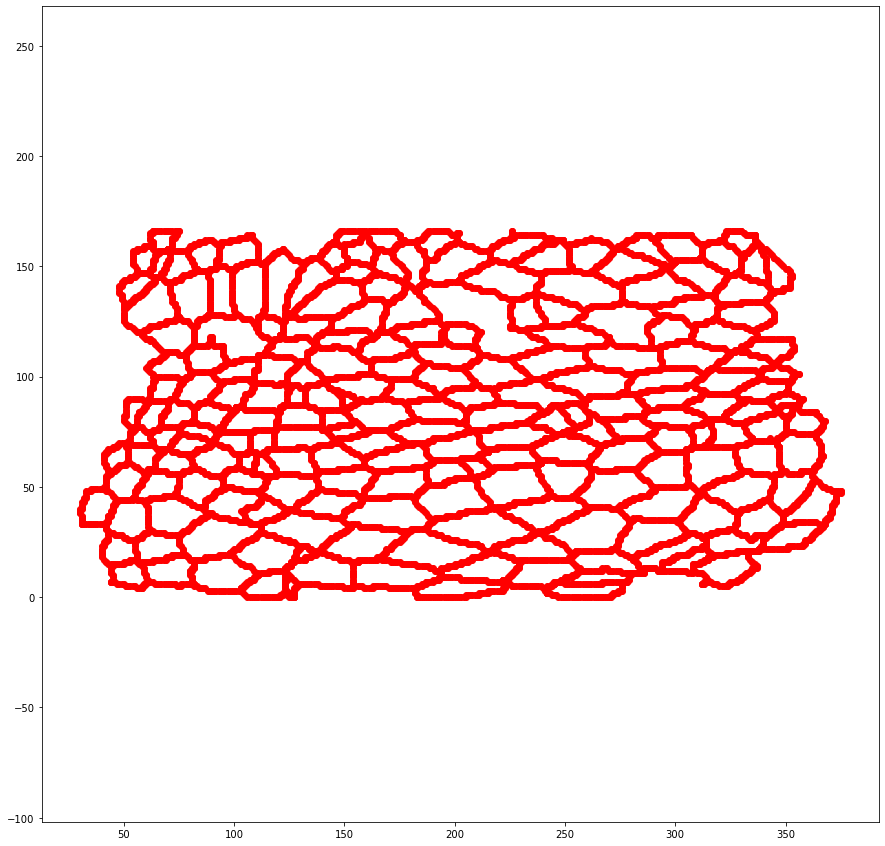

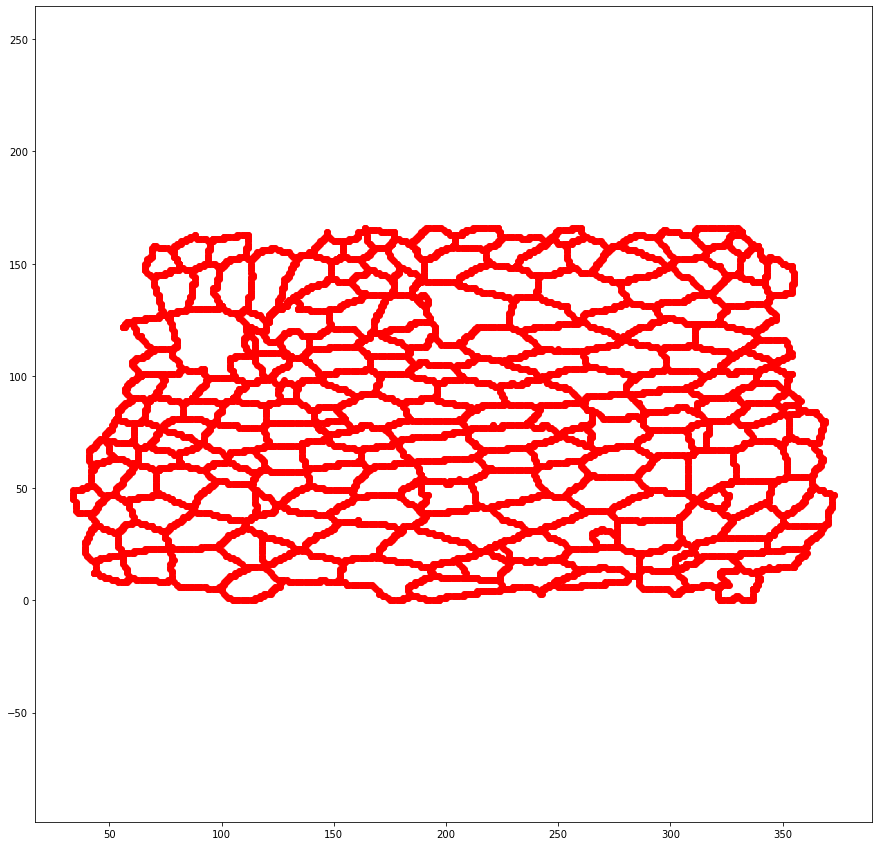

In [6]:
plt.figure(figsize=(15,15))
plt.scatter(skel_t0.point.x, skel_t0.point.y, color='red')
plt.axis('equal')

plt.figure(figsize=(15,15))
plt.scatter(skel_t1.point.x, skel_t1.point.y, color='red')
plt.axis('equal')

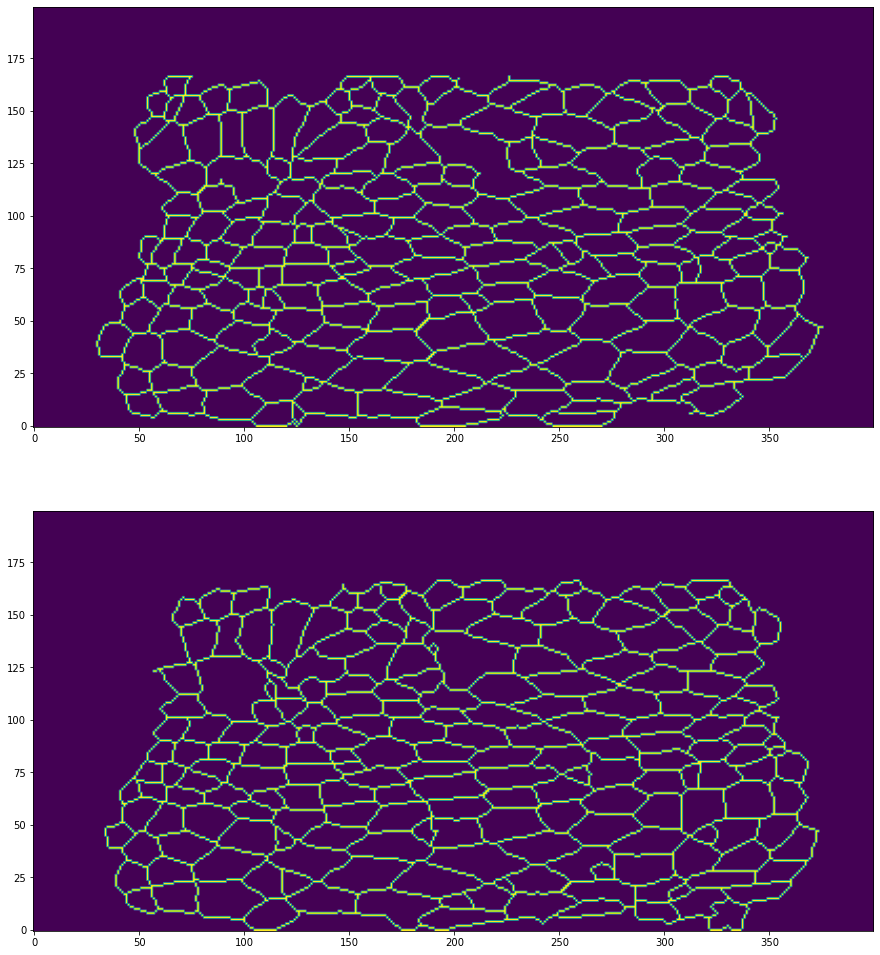

In [7]:
from skimage import morphology
img_output = np.zeros((200,400))
img_output = np.where(img_output>0, 0, img_output) 
w = 0

for _, p in skel_t0.point.iterrows(): 
    if w != 0:
            for y_ in range(int(p.y)-w,int(p.y)+w):
                for x_ in range(int(p.x)-w,int(p.x)+w):
                    try:
                        img_output[y_][x_]=1
                    except:
                        pass
    else : 
        x_=int(p.x)
        y_=int(p.y)
        img_output[y_][x_]=1
img_binary_3d = img_output.copy()

# Need a skeletonization to avoid vertex detection problem
img_binary_t0 = morphology.skeletonize(img_binary_3d)


img_output = np.zeros((200,400))
img_output = np.where(img_output>0, 0, img_output) 
w = 0

for _, p in skel_t1.point.iterrows(): 
    if w != 0:
            for y_ in range(int(p.y)-w,int(p.y)+w):
                for x_ in range(int(p.x)-w,int(p.x)+w):
                    try:
                        img_output[y_][x_]=1
                    except:
                        pass
    else : 
        x_=int(p.x)
        y_=int(p.y)
        img_output[y_][x_]=1
img_binary_3d = img_output.copy()

# Need a skeletonization to avoid vertex detection problem
img_binary_t1 = morphology.skeletonize(img_binary_3d)
    
    
plt.figure(figsize=(17,17))
ax1 = plt.subplot(2,1,1)
ax1.imshow(img_binary_t0,origin='lower')
ax2 = plt.subplot(2,1,2)
ax2.imshow(img_binary_t1,origin='lower')



In [8]:
from Dissects.segmentation.seg_2D import segmentation, junction_around_cell
min_area = 150
seg_t0 = segmentation(img_binary_t0.astype(int), min_area=min_area)
seg_t1 = segmentation(img_binary_t1.astype(int), min_area=min_area)

Text(0.5, 1.0, 'seg')

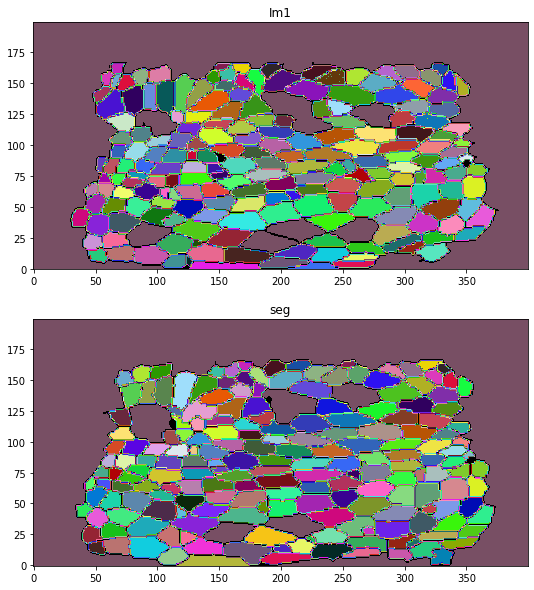

In [114]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(seg_t0,origin='lower',cmap=cmap_rand)
ax1.set_title('Im1')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg_t1,origin='lower',cmap=cmap_rand)
ax2.set_title('seg')

In [11]:
from Dissects.segmentation.seg_2D import generate_mesh

In [12]:
face_df_t0, edge_df_t0, vert_df_t0 = generate_mesh(img_binary_t0, seg_t0,)
face_df_t1, edge_df_t1, vert_df_t1 = generate_mesh(img_binary_t1, seg_t1,)

In [125]:
from Dissects.mesh.core import Mesh, Element, Node
from Dissects.tracking.core import track, DataCollector, find_maximum_common_subgraph


In [124]:
%pdb

Automatic pdb calling has been turned OFF


In [105]:
nodes=[]
elements=[]
for i, val in vert_df_t0.iterrows():
    nodes.append(Node(val[['x','y']]))
    
for f in face_df_t0.index[1:]:
    vert_ = np.unique(edge_df_t0[(edge_df_t0.cell1==f) | (edge_df_t0.cell2==f)][['v1','v2']].to_numpy().flatten())
    angle_ = np.arctan2((vert_df_t0.loc[vert_] - face_df_t0.loc[f][list('xy')])['y'].to_numpy().astype('float'),
           (vert_df_t0.loc[vert_] - face_df_t0.loc[f][list('xy')])['x'].to_numpy().astype('float'),)
    df_tmp = pd.DataFrame({'id':vert_, 'angle':angle_})
    df_tmp.sort_values('angle', inplace=True)

    region=[]
    for v in df_tmp.id.to_numpy():
        region.append(nodes[v])
    elements.append(Element(region))
mesh_t0 = Mesh(nodes, elements)

In [106]:
nodes=[]
elements=[]
for i, val in vert_df_t1.iterrows():
    nodes.append(Node(val[['x','y']]))
    
for f in face_df_t1.index[1:]:
    vert_ = np.unique(edge_df_t1[(edge_df_t1.cell1==f) | (edge_df_t1.cell2==f)][['v1','v2']].to_numpy().flatten())
    angle_ = np.arctan2((vert_df_t1.loc[vert_] - face_df_t1.loc[f][list('xy')])['y'].to_numpy().astype('float'),
           (vert_df_t1.loc[vert_] - face_df_t1.loc[f][list('xy')])['x'].to_numpy().astype('float'),)
    df_tmp = pd.DataFrame({'id':vert_, 'angle':angle_})
    df_tmp.sort_values('angle', inplace=True)

    region=[]
    for v in df_tmp.id.to_numpy():
        region.append(nodes[v])
    elements.append(Element(region))
mesh_t1 = Mesh(nodes, elements)

In [129]:
mesh_t0.assign_frame_ids_in_order()
mesh_t1.assign_frame_ids_randomly()
tracked_ids = find_maximum_common_subgraph( mesh_t0, mesh_t1 )

for element in mesh_t0.elements:
    element.global_id = None

for element in mesh_t1.elements:
    element.global_id = None

# tracked_ids_all = track( mesh_one, mesh_two )
track(mesh_t0, mesh_t1)

AssertionError: 

> /home/admin-suz/miniconda3/lib/python3.8/site-packages/Dissects-0.0.1-py3.8.egg/Dissects/mesh/core.py(399)generate_network()
    397             cells_along_this_edge = self.find_elements_at_edge(edge)
    398             if len(cells_along_this_edge) > 1:
--> 399                 assert( len(cells_along_this_edge) == 2)
    400                 network_edges.append(cells_along_this_edge)
    401 

ipdb> cells_along_this_edge
[160, 161, 163, 149]
ipdb> c


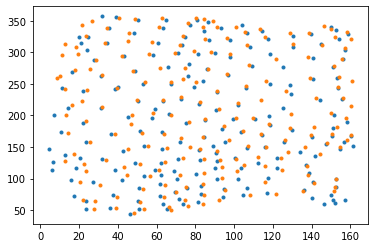

In [23]:
plt.plot(face_df_t0.x, face_df_t0.y, '.')
plt.plot(face_df_t1.x, face_df_t1.y, '.')

In [20]:
face_df_t0

,x,y
1,39.846154,244.615385
2,6.2,113.0
3,4.25,147.5
4,7.0,200.0
7,6.666667,125.666667
...,...,...
199,158.333333,190.333333
200,159.0,329.333333
201,157.333333,66.666667
202,160.25,168.0
